# 1. 불러오기

## 1.1 라이브러리 불러오기

In [1]:
from en_system_ex_analysis.En_system_intergrated import *
from SALib.sample import saltelli
from SALib.analyze import sobol
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import dartwork_mpl as dm
import en_system_ex_analysis as cu
import seaborn as sns
from scipy.stats import norm, uniform, triang, gamma
import warnings
from pprint import pprint
warnings.filterwarnings("ignore")
import matplotlib.colors as mcolors
from matplotlib.cm import get_cmap
from mpl_toolkits.axes_grid1 import make_axes_locatable

dm.use_style()

Load colors...
Load colormaps...


## 1.2 파일 불러오기

In [3]:
# small office 데이터 파일 불러오기
file_path = 'data/'
small_office_df = pd.read_csv(file_path + 'small_office_hour.csv')

# 데이터프레임의 컬럼 이름 프린트
print(small_office_df.columns)

FileNotFoundError: [Errno 2] No such file or directory: 'data/small_office_hour.csv'

## 1.3 주말 삭제

In [ ]:
# 1. Date/Time 열 공백 정리
weekday_df = small_office_df.copy()

# 1. Date/Time 열 공백 정리
weekday_df['Date/Time_clean'] = weekday_df['Date/Time'].str.strip().str.replace(r'\s+', ' ', regex=True)

# 2. 시간 인덱스 기반으로 '요일' 계산 (1월 1일 = 일요일)
weekday_df['Relative_Day_Index'] = weekday_df.index // 24
weekday_df['Weekday'] = (6 + weekday_df['Relative_Day_Index']) % 7 

# 3. 평일 데이터만 필터링 (Weekday 0~4 → 월~금)
weekday_df_weekday = weekday_df[~weekday_df['Weekday'].isin([5, 6])].copy()

# 4. 필요시 인덱스 초기화
weekday_df_weekday.reset_index(drop=True, inplace=True)

# 결과 확인
print(weekday_df_weekday[['Date/Time_clean', 'Weekday']].head(124))


    Date/Time_clean  Weekday
0    01/02 01:00:00        0
1    01/02 02:00:00        0
2    01/02 03:00:00        0
3    01/02 04:00:00        0
4    01/02 05:00:00        0
..              ...      ...
119  01/06 24:00:00        4
120  01/09 01:00:00        0
121  01/09 02:00:00        0
122  01/09 03:00:00        0
123  01/09 04:00:00        0

[124 rows x 2 columns]


## 1.4 환경온도, 실내온도, 부하 리스트 생성

In [ ]:
# 변수(환경온도, 실내온도, 부하) 리스트 생성
Toa_list = weekday_df_weekday['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)'] # 환경온도
Tia_list = weekday_df_weekday['CORE_ZN:Zone Air Temperature [C](TimeStep)'] # 실내온도
cooling_load_list = weekday_df_weekday['DistrictCooling:Facility [J](TimeStep)'] / 3600 # 냉방부하, J -> W
heating_load_list = weekday_df_weekday['DistrictHeatingWater:Facility [J](TimeStep) '] / 3600 # 난방부하, J -> W
ATTIC_ZT = weekday_df_weekday['ATTIC:Zone Air Temperature [C](TimeStep)'] # 옥상 온도
CORE_ZT = weekday_df_weekday['CORE_ZN:Zone Air Temperature [C](TimeStep)'] # 실내 온도
PERIMETER_Z1T = weekday_df_weekday['PERIMETER_ZN_1:Zone Air Temperature [C](TimeStep)'] # 주변 온도
PERIMETER_Z2T = weekday_df_weekday['PERIMETER_ZN_2:Zone Air Temperature [C](TimeStep)'] # 주변 온도
PERIMETER_Z3T = weekday_df_weekday['PERIMETER_ZN_3:Zone Air Temperature [C](TimeStep)'] # 주변 온도
PERIMETER_Z4T = weekday_df_weekday['PERIMETER_ZN_4:Zone Air Temperature [C](TimeStep)'] # 주변 온도
Date = weekday_df_weekday['Date/Time'] # 날짜

Zone_temp_list = [CORE_ZT, PERIMETER_Z1T, PERIMETER_Z2T, PERIMETER_Z3T, PERIMETER_Z4T]

# 리스트 길이 확인
len(Toa_list), len(Tia_list), len(cooling_load_list), len(heating_load_list)

(6240, 6240, 6240, 6240)

In [ ]:
# 냉난방 부하 최대, 최소 확인
max(cooling_load_list), min(cooling_load_list), max(heating_load_list), min(heating_load_list)

(23746.545957423623, 0.0, 27407.72705044015, 0.0)

# 2. 엑서지 아웃풋 분석

##  2.1 엑서지 아웃풋 리스트 생성

엑서지 아웃풋 분석을 위한 데이터 생성

In [14]:
# 변수(환경온도, 실내온도, 부하) 리스트 생성
Toa_list = small_office_df['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)'] # 환경온도
Tia_list = small_office_df['CORE_ZN:Zone Air Temperature [C](TimeStep)'] # 실내온도
cooling_load_list = small_office_df['DistrictCooling:Facility [J](TimeStep)'] / 3600 # 냉방부하, J -> W
heating_load_list = small_office_df['DistrictHeatingWater:Facility [J](TimeStep) '] / 3600 # 난방부하, J -> W
ATTIC_ZT = small_office_df['ATTIC:Zone Air Temperature [C](TimeStep)'] # 옥상 온도
CORE_ZT = small_office_df['CORE_ZN:Zone Air Temperature [C](TimeStep)'] # 실내 온도
PERIMETER_Z1T = small_office_df['PERIMETER_ZN_1:Zone Air Temperature [C](TimeStep)'] # 주변 온도
PERIMETER_Z2T = small_office_df['PERIMETER_ZN_2:Zone Air Temperature [C](TimeStep)'] # 주변 온도
PERIMETER_Z3T = small_office_df['PERIMETER_ZN_3:Zone Air Temperature [C](TimeStep)'] # 주변 온도
PERIMETER_Z4T = small_office_df['PERIMETER_ZN_4:Zone Air Temperature [C](TimeStep)'] # 주변 온도
Date = small_office_df['Date/Time'] # 날짜

Zone_temp_list = [CORE_ZT, PERIMETER_Z1T, PERIMETER_Z2T, PERIMETER_Z3T, PERIMETER_Z4T]

# 리스트 길이 확인
len(Toa_list), len(Tia_list), len(cooling_load_list), len(heating_load_list)

(8760, 8760, 8760, 8760)

In [15]:
ASHP_cooling_output = []
ASHP_heating_output = []

for Toa, Tia, cooling_load, heating_load in zip(Toa_list, Tia_list, cooling_load_list, heating_load_list):
    if cooling_load == 0 and heating_load == 0:
        # 냉난방 부하가 없을 때
        ASHP_cooling_output.append(0)
        ASHP_heating_output.append(0)
    else:
        if cooling_load > 0:
            # 냉방 작동
            ASHP_cooling = AirSourceHeatPump_cooling()
            ASHP_cooling.T_0 = cu.C2K(Toa)
            ASHP_cooling.T_a_int_in = cu.C2K(Tia)
            ASHP_cooling.Q_r_int = cooling_load
            ASHP_cooling.COP_model.max_cooling_load = max(cooling_load_list)
            ASHP_cooling.system_update()
            net_cool_exergy = ASHP_cooling.X_a_int_out - ASHP_cooling.X_a_int_in
            ASHP_cooling_output.append(net_cool_exergy)
        else:
            ASHP_cooling_output.append(0)
        
        if heating_load > 0:
            # 난방 작동
            ASHP_heating = AirSourceHeatPump_heating()
            ASHP_heating.T_0 = cu.C2K(Toa)
            ASHP_heating.T_a_int_in = cu.C2K(Tia)
            ASHP_heating.Q_r_int = heating_load
            ASHP_heating.COP_model.max_heating_load = max(heating_load_list)
            ASHP_heating.system_update()
            net_warm_exergy = ASHP_heating.X_a_int_out - ASHP_heating.X_a_int_in
            ASHP_heating_output.append(net_warm_exergy)
        else:
            ASHP_heating_output.append(0)

len(ASHP_cooling_output), len(ASHP_heating_output)

(8760, 8760)

### 2.1.1 순 냉엑서지 아웃풋일 때의 날짜, 시간, 온도, 엑서지 확인

In [16]:
ASHP_cooling_output = []
ASHP_heating_output = []

for idx, (Toa, Tia, cooling_load, heating_load) in enumerate(zip(Toa_list, Tia_list, cooling_load_list, heating_load_list)):
    if cooling_load == 0 and heating_load == 0:
        # 냉난방 부하가 없을 때
        ASHP_cooling_output.append(0)
        ASHP_heating_output.append(0)
    else:
        if cooling_load > 0:
            # 냉방 작동
            ASHP_cooling = AirSourceHeatPump_cooling()
            ASHP_cooling.T_0 = cu.C2K(Toa)
            ASHP_cooling.T_a_int_in = cu.C2K(Tia)
            ASHP_cooling.Q_r_int = cooling_load
            ASHP_cooling.COP_model.max_cooling_load = max(cooling_load_list)
            ASHP_cooling.system_update()
            net_cool_exergy = ASHP_cooling.X_a_int_out - ASHP_cooling.X_a_int_in
            
            # 디버깅을 위한 출력
            if net_cool_exergy < 0:
                print("\n\nDate" + "-"*10)
                print(Date[idx])
                print(" ")
                print("TEMPERATURE" + "-"*10)
                print(f"T_a_int_in: {round(cu.K2C(ASHP_cooling.T_a_int_in),2)}")
                print(f"T_a_int_out: {round(cu.K2C(ASHP_cooling.T_a_int_out),2)}")
                print(f"T_0: {round(cu.K2C(ASHP_cooling.T_0),2)}")
                for zone_temp in Zone_temp_list:
                    print(f"Zone_temp: {round(zone_temp[idx],2)}")
                print(" ")
                print("COOLING LOAD [W]" + "-"*10)
                print(round(cooling_load,2))
                print(" ")
                print("EXERGY" + "-"*10)
                print(f"X_a_int_in: {round(ASHP_cooling.X_a_int_in,2)}")
                print(f"X_a_int_out: {round(ASHP_cooling.X_a_int_out,2)}")

            ASHP_cooling_output.append(net_cool_exergy)
        else:
            ASHP_cooling_output.append(0)
        
        if heating_load > 0:
            # 난방 작동
            ASHP_heating = AirSourceHeatPump_heating()
            ASHP_heating.T_0 = cu.C2K(Toa)
            ASHP_heating.T_a_int_in = cu.C2K(Tia)
            ASHP_heating.Q_r_int = heating_load
            ASHP_heating.COP_model.max_heating_load = max(heating_load_list)
            ASHP_heating.system_update()
            net_warm_exergy = ASHP_heating.X_a_int_out - ASHP_heating.X_a_int_in
            ASHP_heating_output.append(net_warm_exergy)
        else:
            ASHP_heating_output.append(0)

len(ASHP_cooling_output), len(ASHP_heating_output)



Date----------
 01/03  14:00:00
 
TEMPERATURE----------
T_a_int_in: 22.0
T_a_int_out: 12.0
T_0: 5.2
Zone_temp: 22.0
Zone_temp: 22.0
Zone_temp: 22.0
Zone_temp: 22.0
Zone_temp: 22.0
 
COOLING LOAD [W]----------
20.68
 
EXERGY----------
X_a_int_in: 1.01
X_a_int_out: 0.17


Date----------
 01/03  15:00:00
 
TEMPERATURE----------
T_a_int_in: 22.0
T_a_int_out: 12.0
T_0: 5.4
Zone_temp: 22.0
Zone_temp: 22.0
Zone_temp: 22.0
Zone_temp: 22.0
Zone_temp: 22.0
 
COOLING LOAD [W]----------
141.04
 
EXERGY----------
X_a_int_in: 6.71
X_a_int_out: 1.09


Date----------
 01/04  13:00:00
 
TEMPERATURE----------
T_a_int_in: 22.0
T_a_int_out: 12.0
T_0: 2.8
Zone_temp: 22.0
Zone_temp: 22.0
Zone_temp: 22.0
Zone_temp: 22.0
Zone_temp: 22.0
 
COOLING LOAD [W]----------
872.89
 
EXERGY----------
X_a_int_in: 55.73
X_a_int_out: 13.1


Date----------
 01/04  14:00:00
 
TEMPERATURE----------
T_a_int_in: 22.0
T_a_int_out: 12.0
T_0: 4.1
Zone_temp: 22.0
Zone_temp: 22.0
Zone_temp: 22.0
Zone_temp: 22.0
Zone_temp: 22.0
 


(8760, 8760)

### 2.1.2 순 온엑서지 아웃풋일 때의 날짜, 시간, 온도, 엑서지 확인

In [17]:
ASHP_cooling_output = []
ASHP_heating_output = []

for idx, (Toa, Tia, cooling_load, heating_load) in enumerate(zip(Toa_list, Tia_list, cooling_load_list, heating_load_list)):
    if cooling_load == 0 and heating_load == 0:
        # 냉난방 부하가 없을 때
        ASHP_cooling_output.append(0)
        ASHP_heating_output.append(0)
    else:
        if cooling_load > 0:
            # 냉방 작동
            ASHP_cooling = AirSourceHeatPump_cooling()
            ASHP_cooling.T_0 = cu.C2K(Toa)
            ASHP_cooling.T_a_int_in = cu.C2K(Tia)
            ASHP_cooling.Q_r_int = cooling_load
            ASHP_cooling.COP_model.max_cooling_load = max(cooling_load_list)
            ASHP_cooling.system_update()
            net_cool_exergy = ASHP_cooling.X_a_int_out - ASHP_cooling.X_a_int_in
            ASHP_cooling_output.append(net_cool_exergy)
        else:
            ASHP_cooling_output.append(0)
        
        if heating_load > 0:
            # 난방 작동
            ASHP_heating = AirSourceHeatPump_heating()
            ASHP_heating.T_0 = cu.C2K(Toa)
            ASHP_heating.T_a_int_in = cu.C2K(Tia)
            ASHP_heating.Q_r_int = heating_load
            ASHP_heating.COP_model.max_heating_load = max(heating_load_list)
            ASHP_heating.system_update()
            net_warm_exergy = ASHP_heating.X_a_int_out - ASHP_heating.X_a_int_in
            ASHP_heating_output.append(net_warm_exergy)
            # 디버깅을 위한 출력
            if net_warm_exergy < 0:
                print("\n\nDate" + "-"*10)
                print(Date[idx])
                print(" ")
                print("TEMPERATURE" + "-"*10)
                print(f"T_a_int_in: {round(cu.K2C(ASHP_heating.T_a_int_in),2)}")
                print(f"T_a_int_out: {round(cu.K2C(ASHP_heating.T_a_int_out),2)}")
                print(f"T_0: {round(cu.K2C(ASHP_heating.T_0),2)}")
                for zone_temp in Zone_temp_list:
                    print(f"Zone_temp: {round(zone_temp[idx],2)}")
                print(" ")
                print("HEATING LOAD [W]" + "-"*10)
                print(round(heating_load,2))
                print(" ")
                print("EXERGY" + "-"*10)
                print(f"X_a_int_in: {round(ASHP_heating.X_a_int_in,2)}")
                print(f"X_a_int_out: {round(ASHP_heating.X_a_int_out,2)}")
        else:
            ASHP_heating_output.append(0)

len(ASHP_cooling_output), len(ASHP_heating_output)



Date----------
 07/01  17:00:00
 
TEMPERATURE----------
T_a_int_in: 22.0
T_a_int_out: 32.0
T_0: 27.3
Zone_temp: 22.0
Zone_temp: 22.0
Zone_temp: 22.0
Zone_temp: 22.0
Zone_temp: 22.0
 
HEATING LOAD [W]----------
97.82
 
EXERGY----------
X_a_int_in: 0.46
X_a_int_out: 0.36


Date----------
 07/08  17:00:00
 
TEMPERATURE----------
T_a_int_in: 22.0
T_a_int_out: 32.0
T_0: 27.2
Zone_temp: 22.0
Zone_temp: 22.0
Zone_temp: 22.0
Zone_temp: 22.0
Zone_temp: 22.0
 
HEATING LOAD [W]----------
68.25
 
EXERGY----------
X_a_int_in: 0.31
X_a_int_out: 0.26


Date----------
 08/26  17:00:00
 
TEMPERATURE----------
T_a_int_in: 22.0
T_a_int_out: 32.0
T_0: 27.9
Zone_temp: 22.0
Zone_temp: 22.0
Zone_temp: 22.0
Zone_temp: 22.0
Zone_temp: 22.0
 
HEATING LOAD [W]----------
42.71
 
EXERGY----------
X_a_int_in: 0.25
X_a_int_out: 0.12


(8760, 8760)

## 2.2 엑서지 아웃풋 그래프

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Set up the plot
fig, ax = plt.subplots(figsize=(dm.cm2in(9), dm.cm2in(5)))

# Fontsize
label_fontsize = dm.fs(-2)
tick_fontsize = dm.fs(-2)
legend_fontsize = dm.fs(-2.5)

# Common setting
line_width = 0.4
major_tick_width = 0.3
minor_tick_width = 0.1

# Limit
plt.xlim(0, 8760)
plt.ylim(-70, 2800)

# Label
plt.xlabel('Hour of year [h]', fontsize=label_fontsize)
plt.ylabel('Exergy output of ASHP [W]', fontsize=label_fontsize)

# Tick
plt.xticks(np.linspace(0, 8760, 7))
plt.yticks(np.linspace(-80, 2800, 4))
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize, width=major_tick_width)
plt.tick_params(axis='both', which='minor', labelsize=tick_fontsize, width=minor_tick_width)

# Plot
plt.plot(ASHP_cooling_output, label='Cooling', color='dm.blue4', linewidth=line_width, alpha=0.8)
plt.plot(ASHP_heating_output, label='Heating', color='dm.red4', linewidth=line_width, alpha=0.8)

# Legend
plt.legend(
    labels=['Cooling', 'Heating'],
    loc='upper right', ncol=2, frameon=False,
    fontsize=legend_fontsize, fancybox=False,
    columnspacing=1.00, labelspacing=0.8,
    bbox_to_anchor=(0.95, 0.97),
    handlelength=1.8
)

plt.tight_layout()
plt.grid(True)
plt.savefig('figure/exergy_output.png', dpi=600)
dm.util.save_and_show(fig)

# 3. 엑서지 효율 분석

## 3.1 엑서지 효율 계산 및 리스트 생성

In [20]:
# 부하가 음수인 경우 확인
print("Cooling load < 0: ", len([x for x in cooling_load_list if x < 0]))
print("Heating load < 0: ", len([x for x in heating_load_list if x < 0]))

Cooling load < 0:  0
Heating load < 0:  0


In [21]:
ASHP_cooling_exergy_effi = []
ASHP_heating_exergy_effi = []

for Toa, Tia, cooling_load, heating_load in zip(Toa_list, Tia_list, cooling_load_list, heating_load_list):
    # 냉방 엑서지 효율 계산
    if cooling_load > 0:
        ASHP_cooling = AirSourceHeatPump_cooling()
        ASHP_cooling.T_0 = cu.C2K(Toa)
        ASHP_cooling.T_a_int_in = cu.C2K(Tia)
        ASHP_cooling.Q_r_int = cooling_load
        ASHP_cooling.COP_model.max_cooling_load = max(cooling_load_list)
        ASHP_cooling.system_update()
        cooling_exergy_efficiency = ASHP_cooling.Xout_int / (ASHP_cooling.E_fan_int + ASHP_cooling.E_cmp + ASHP_cooling.E_fan_ext)
        if ASHP_cooling.Xout_int < 0:
            ASHP_cooling_exergy_effi.append(None)
        else:
            ASHP_cooling_exergy_effi.append(cooling_exergy_efficiency)
    else:
        ASHP_cooling_exergy_effi.append(None)

    # 난방 엑서지 효율 계산
    if heating_load > 0:
        ASHP_heating = AirSourceHeatPump_heating()
        ASHP_heating.T_0 = cu.C2K(Toa)
        ASHP_heating.T_a_int_in = cu.C2K(Tia)
        ASHP_heating.Q_r_int = heating_load
        ASHP_heating.COP_model.max_heating_load = max(heating_load_list)
        ASHP_heating.system_update()
        heating_exergy_efficiency = ASHP_heating.Xout_int / (ASHP_heating.E_fan_int + ASHP_heating.E_cmp + ASHP_heating.E_fan_ext)
        if ASHP_heating.Xout_int < 0:
            ASHP_heating_exergy_effi.append(None)
        else:
            ASHP_heating_exergy_effi.append(heating_exergy_efficiency)
    else:
        ASHP_heating_exergy_effi.append(None)

# 엑서지효율 None 제거
ASHP_cooling_exergy_effi_filtered = [x for x in ASHP_cooling_exergy_effi if x is not None]
ASHP_heating_exergy_effi_filtered = [x for x in ASHP_heating_exergy_effi if x is not None]

# 엑서지효율 None 값일 때 해당하는 온도, 부하를 제거한 필터링된 리스트
Toa_cooling_list_filtered = [Toa for Toa, eff in zip(Toa_list, ASHP_cooling_exergy_effi) if eff is not None]
Toa_heating_list_filtered = [Toa for Toa, eff in zip(Toa_list, ASHP_heating_exergy_effi) if eff is not None]
cooling_load_list_filtered = [load for load, eff in zip(cooling_load_list, ASHP_cooling_exergy_effi) if eff is not None]
heating_load_list_filtered = [load for load, eff in zip(heating_load_list, ASHP_heating_exergy_effi) if eff is not None]


In [22]:
# 엑서지효율 최소 최대 확인
print("Cooling exergy efficiency: ", min(ASHP_cooling_exergy_effi_filtered), max(ASHP_cooling_exergy_effi_filtered))
print("Heating exergy efficiency: ", min(ASHP_heating_exergy_effi_filtered), max(ASHP_heating_exergy_effi_filtered))

Cooling exergy efficiency:  2.5015200494735904e-06 0.19672400966170364
Heating exergy efficiency:  0.02463107343465609 0.36282851945289757


In [23]:
# 부하 최소 최대 확인
print("Cooling load: ", min(cooling_load_list_filtered), max(cooling_load_list_filtered))
print("Heating load: ", min(heating_load_list_filtered), max(heating_load_list_filtered))

Cooling load:  2.134920433101956 23746.545957423623
Heating load:  0.09331977998181172 27407.72705044015


## 3.2 엑서지 효율 그래프

냉방, 난방 모드별 엑서지 효율 그래프

In [24]:
# seismic 컬러맵의 왼쪽 절반만 사용
seismic_left = mcolors.LinearSegmentedColormap.from_list(
    'seismic_left', get_cmap('seismic')(np.linspace(0, 0.5, 256))
)

# seismic 컬러맵의 오른쪽 절반만 사용
seismic_right = mcolors.LinearSegmentedColormap.from_list(
    'seismic_right', get_cmap('seismic')(np.linspace(0.5, 1.0, 256))
)

# Set up the plot
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(dm.cm2in(14), dm.cm2in(12)))
plt.subplots_adjust(left=0.11, right=0.99, top=0.95, bottom=0.1, wspace=0.2, hspace=0.4)

# Fontsize
label_fontsize = dm.fs(0.5)
tick_fontsize = dm.fs(0)
title_fontsize = dm.fs(-1)
cbar_fontsize = dm.fs(-1)

# Common setting
label_pad =  7
line_width = 0

# Normalize for colorbar
norm_cooling = mcolors.Normalize(vmin=min(ASHP_cooling_exergy_effi_filtered)*100, vmax=max(ASHP_cooling_exergy_effi_filtered)*100)
norm_heating = mcolors.Normalize(vmin=min(ASHP_heating_exergy_effi_filtered)*100, vmax=max(ASHP_heating_exergy_effi_filtered)*100)

# Scatter plot
sc1 = ax[0].scatter(Toa_cooling_list_filtered, 
                    [load / 1000 for load in cooling_load_list_filtered],
                    c = [eff * 100 for eff in ASHP_cooling_exergy_effi_filtered],
                    cmap = seismic_left.reversed(),
                    s=2.5, alpha=0.8, norm=norm_cooling,
                    facecolors='none', linewidths=line_width, edgecolors='none') 
cbar1 = fig.colorbar(sc1, ax=ax[0])
cbar1.set_ticks(np.linspace(min(ASHP_cooling_exergy_effi_filtered)*100, max(ASHP_cooling_exergy_effi_filtered)*100, 5))
cbar1.ax.tick_params(labelsize=cbar_fontsize)
cbar1.set_label('Exergy efficiency [%]', fontsize=cbar_fontsize, labelpad=label_pad)

sc2 = ax[1].scatter(Toa_heating_list_filtered, 
                    [load / 1000 for load in heating_load_list_filtered],
                    c = [eff * 100 for eff in ASHP_heating_exergy_effi_filtered],
                    cmap = seismic_right,
                    s=2.5, alpha=0.8, norm=norm_heating, 
                    facecolors='none', linewidths=line_width, edgecolors='none')
cbar2 = fig.colorbar(sc2, ax=ax[1])
cbar2.set_ticks(np.linspace(min(ASHP_heating_exergy_effi_filtered)*100, max(ASHP_heating_exergy_effi_filtered)*100, 5))
cbar2.ax.tick_params(labelsize=cbar_fontsize)
cbar2.set_label('Exergy efficiency [%]', fontsize=cbar_fontsize, labelpad=label_pad)

# limit
ax[0].set_xlim(-5, max(Toa_cooling_list_filtered) + 1)
ax[0].set_ylim(0, 30)

ax[1].set_xlim(-5, max(Toa_heating_list_filtered) + 1)
ax[1].set_ylim(0, 30)

# Label 
ax[0].set_xlabel('Environmental temperature [°C]', fontsize=label_fontsize)
ax[0].set_ylabel('Cooling load [kW]', fontsize=label_fontsize, labelpad=label_pad)

ax[1].set_xlabel('Environmental temperature [°C]', fontsize=label_fontsize)
ax[1].set_ylabel('Heating load [kW]', fontsize=label_fontsize, labelpad=label_pad)

# Tick
ax[0].set_xticks(np.arange(-10, 36, 5))
ax[0].set_yticks(np.linspace(0, 30, 7))
ax[0].tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax[0].tick_params(axis='both', which='minor', labelsize=tick_fontsize)

ax[1].set_xticks(np.arange(-10, 36, 5))
ax[1].set_yticks(np.linspace(0, 30, 7))
ax[1].tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax[1].tick_params(axis='both', which='minor', labelsize=tick_fontsize)

ax[0].grid(True)
ax[1].grid(True)

# Subplot title
ax[0].text(0.01, 1.09, '(a) Cooling mode', transform=ax[0].transAxes, fontsize=title_fontsize, va='top', ha='left')
ax[1].text(0.01, 1.09, '(b) Heating mode', transform=ax[1].transAxes, fontsize=title_fontsize, va='top', ha='left')

plt.savefig('figure/exergy_efficiency.png', dpi=600)
dm.util.save_and_show(fig)

냉난방 모드를 하나의 그래프에 그리기

In [25]:
# seismic 컬러맵의 왼쪽 절반만 사용
seismic_left = mcolors.LinearSegmentedColormap.from_list(
    'seismic_left', get_cmap('seismic')(np.linspace(0, 0.5, 256))
)

# seismic 컬러맵의 오른쪽 절반만 사용
seismic_right = mcolors.LinearSegmentedColormap.from_list(
    'seismic_right', get_cmap('seismic')(np.linspace(0.5, 1.0, 256))
)

# Set up the plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(dm.cm2in(14), dm.cm2in(7)))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.15, wspace=0.1, hspace=0.1)

# 메인 축을 기준으로 divider 생성
divider = make_axes_locatable(ax)

# Fontsize
label_fontsize = dm.fs(0.5)
tick_fontsize = dm.fs(-0.5)
cbar_fontsize = dm.fs(-1.5)
cbar_title_fontsize = dm.fs(-1.2)

# Common setting
label_pad = 8

# Normalize for colorbar
norm_cooling = mcolors.Normalize(vmin=min(ASHP_cooling_exergy_effi_filtered)*100, vmax=max(ASHP_cooling_exergy_effi_filtered)*100)
norm_heating = mcolors.Normalize(vmin=min(ASHP_heating_exergy_effi_filtered)*100, vmax=max(ASHP_heating_exergy_effi_filtered)*100)

# Scatter plot
cax1 = divider.append_axes("right", size="3%", pad=0.2)
sc1 = ax.scatter(Toa_cooling_list_filtered, 
                 [load / 1000 for load in cooling_load_list_filtered], 
                 c=[eff * 100 for eff in ASHP_cooling_exergy_effi_filtered],
                 cmap=seismic_left.reversed(), 
                 s=2.5, alpha=0.8, norm=norm_cooling,
                 facecolors='none', linewidths=line_width, edgecolors='none')
cbar1 = fig.colorbar(sc1, cax=cax1)
cbar1.set_ticks(np.linspace(min(ASHP_cooling_exergy_effi_filtered)*100, max(ASHP_cooling_exergy_effi_filtered)*100, 5))
cbar1.ax.tick_params(labelsize=cbar_fontsize)
cbar1.ax.text(0.5, 1.03, 'Cooling', fontsize=cbar_title_fontsize, ha='center', va='bottom', transform=cbar1.ax.transAxes)

cax2 = divider.append_axes("right", size="3%", pad=0.4)
sc2 = ax.scatter(Toa_heating_list_filtered, 
                 [load / 1000 for load in heating_load_list_filtered], 
                 c=[eff * 100 for eff in ASHP_heating_exergy_effi_filtered], 
                 cmap=seismic_right, 
                 s=2.5, alpha=0.8, norm=norm_heating,
                 facecolors='none', linewidths=line_width, edgecolors='none')
cbar2 = fig.colorbar(sc2, cax=cax2)
cbar2.set_ticks(np.linspace(min(ASHP_heating_exergy_effi_filtered)*100, max(ASHP_heating_exergy_effi_filtered)*100, 5))
cbar2.ax.tick_params(labelsize=cbar_fontsize)
cbar2.set_label('Exergy efficiency [%]', fontsize=cbar_fontsize, labelpad=label_pad)
cbar2.ax.text(0.5, 1.03, 'Heating', fontsize=cbar_title_fontsize, ha='center', va='bottom', transform=cbar2.ax.transAxes)

# limit
ax.set_xlim(-10, 35)
ax.set_ylim(0, 30)

# label
ax.set_xlabel('Environmental temperature [°C]', fontsize=label_fontsize)
ax.set_ylabel('Load [kW]', fontsize=label_fontsize, labelpad=label_pad)

# Tick
ax.set_xticks(np.arange(-10, 36, 5))
ax.set_yticks(np.linspace(0, 30, 7))
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax.tick_params(axis='both', which='minor', labelsize=tick_fontsize)

ax.grid(True)

plt.savefig('figure/exergy_efficiency_one_graph_divide_mode.png', dpi=600)
dm.util.save_and_show(fig)

## 3.3 엑서지 효율 분석

난방 모드에서 엑서지 효율이 모여있는 곳에서 많이 벗어나있는 곳 분석

In [ ]:
# 필요한 열 정리 및 변환
weekday_df_weekday['Toa'] = weekday_df_weekday['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)']
weekday_df_weekday['Heating Load (kW)'] = weekday_df_weekday['DistrictHeatingWater:Facility [J](TimeStep) '] / 3600 / 1000
weekday_df_weekday['DateTime'] = weekday_df_weekday['Date/Time']

# 조건에 맞는 행 필터링
filtered_weekday_df_weekday1 = weekday_df_weekday[(weekday_df_weekday['Heating Load (kW)'] >= 0) &
                 (weekday_df_weekday['Heating Load (kW)'] <= 2) &
                 (weekday_df_weekday['Toa'] <= 5)]

filtered_weekday_df_weekday2 = weekday_df_weekday[(weekday_df_weekday['Heating Load (kW)'] > 15) &
                    (weekday_df_weekday['Heating Load (kW)'] >= 20) &
                    (weekday_df_weekday['Toa'] <= 5)]

# 결과 출력
# print(filtered_weekday_df_weekday1[['DateTime', 'Toa', 'Heating Load (kW)']].head(50))
print(filtered_weekday_df_weekday2[['DateTime', 'Toa', 'Heating Load (kW)']].head(50))

In [ ]:
# 필요한 열 정리 및 변환
small_office_df['Toa'] = small_office_df['Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)']
small_office_df['Heating Load (kW)'] = small_office_df['DistrictHeatingWater:Facility [J](TimeStep) '] / 3600 / 1000
small_office_df['DateTime'] = small_office_df['Date/Time']

# 조건에 맞는 행 필터링
filtered_small_office_df1 = small_office_df[(small_office_df['Heating Load (kW)'] > 0) &
                 (small_office_df['Heating Load (kW)'] <= 2) &
                 (small_office_df['Toa'] <= 5)]

filtered_small_office_df2 = small_office_df[(small_office_df['Heating Load (kW)'] > 0) &
                    (small_office_df['Heating Load (kW)'] >= 20) &
                    (small_office_df['Toa'] <= 5)]

# 결과 출력
# print(filtered_small_office_df1[['DateTime', 'Toa', 'Heating Load (kW)']].head(50))
print(filtered_small_office_df2[['DateTime', 'Toa', 'Heating Load (kW)']].head(50))

# 갯수 확인
# print(len(filtered_small_office_df1))

# 4. 엑서지 인풋, 아웃풋 분석

## 4.1 엑서지 인풋, 아웃풋별 리스트 생성

In [26]:
ASHP_cooling_input_exergy = []
ASHP_heating_input_exergy = []
ASHP_cooling_output_exergy = []
ASHP_heating_output_exergy = []

for Toa, Tia, cooling_load, heating_load in zip(Toa_list, Tia_list, cooling_load_list, heating_load_list):
    if cooling_load > 0:
        ASHP_cooling = AirSourceHeatPump_cooling()
        ASHP_cooling.T_0 = cu.C2K(Toa)
        ASHP_cooling.T_a_int_in = cu.C2K(Tia)
        ASHP_cooling.Q_r_int = cooling_load
        ASHP_cooling.COP_model.max_cooling_load = max(cooling_load_list)
        ASHP_cooling.system_update()
        net_cool_exergy = ASHP_cooling.X_a_int_out - ASHP_cooling.X_a_int_in
        electric_exergy = ASHP_cooling.E_fan_int + ASHP_cooling.E_cmp + ASHP_cooling.E_fan_ext
        if net_cool_exergy < 0:
            ASHP_cooling_output_exergy.append(None)
            ASHP_cooling_input_exergy.append(None)
        else:
            ASHP_cooling_output_exergy.append(net_cool_exergy)
            ASHP_cooling_input_exergy.append(electric_exergy)
    else:
        ASHP_cooling_input_exergy.append(None)
        ASHP_cooling_output_exergy.append(None)

    if heating_load > 0:
        ASHP_heating = AirSourceHeatPump_heating()
        ASHP_heating.T_0 = cu.C2K(Toa)
        ASHP_heating.T_a_int_in = cu.C2K(Tia)
        ASHP_heating.Q_r_int = heating_load
        ASHP_heating.COP_model.max_heating_load = max(heating_load_list)
        ASHP_heating.system_update()
        net_warm_exergy = ASHP_heating.X_a_int_out - ASHP_heating.X_a_int_in
        electric_exergy = ASHP_heating.E_fan_int + ASHP_heating.E_cmp + ASHP_heating.E_fan_ext
        if net_warm_exergy < 0:
            ASHP_heating_output_exergy.append(None)
            ASHP_heating_input_exergy.append(None)
        else:
            ASHP_heating_output_exergy.append(net_warm_exergy)
            ASHP_heating_input_exergy.append(electric_exergy)
    else:
        ASHP_heating_input_exergy.append(None)
        ASHP_heating_output_exergy.append(None)

# 엑서지 인풋 None 제거
ASHP_cooling_input_exergy_filtered = [x for x in ASHP_cooling_input_exergy if x is not None]
ASHP_heating_input_exergy_filtered = [x for x in ASHP_heating_input_exergy if x is not None]
# 엑서지 아웃풋 None 제거
ASHP_cooling_output_exergy_filtered = [x for x in ASHP_cooling_output_exergy if x is not None]
ASHP_heating_output_exergy_filtered = [x for x in ASHP_heating_output_exergy if x is not None]

# 엑서지 인풋 None 값일 때 해당하는 온도, 부하를 제거한 필터링된 리스트
Toa_cooling_list_input_none_filtered = [Toa for Toa, eff in zip(Toa_list, ASHP_cooling_input_exergy) if eff is not None]
Toa_heating_list_input_none_filtered = [Toa for Toa, eff in zip(Toa_list, ASHP_heating_input_exergy) if eff is not None]
cooling_load_list_input_none_filtered = [load for load, eff in zip(cooling_load_list, ASHP_cooling_input_exergy) if eff is not None]
heating_load_list_input_none_filtered = [load for load, eff in zip(heating_load_list, ASHP_heating_input_exergy) if eff is not None]
# 엑서지 아웃풋 None 값일 때 해당하는 온도, 부하를 제거한 필터링된 리스트
Toa_cooling_list_output_none_filtered = [Toa for Toa, eff in zip(Toa_list, ASHP_cooling_output_exergy) if eff is not None]
Toa_heating_list_output_none_filtered = [Toa for Toa, eff in zip(Toa_list, ASHP_heating_output_exergy) if eff is not None]
cooling_load_list_output_none_filtered = [load for load, eff in zip(cooling_load_list, ASHP_cooling_output_exergy) if eff is not None]
heating_load_list_output_none_filtered = [load for load, eff in zip(heating_load_list, ASHP_heating_output_exergy) if eff is not None]

## 4.2 엑서지 인풋 그래프

In [28]:
# seismic 컬러맵의 왼쪽 절반만 사용
seismic_left = mcolors.LinearSegmentedColormap.from_list(
    'seismic_left', get_cmap('seismic')(np.linspace(0, 0.5, 256))
)

# seismic 컬러맵의 오른쪽 절반만 사용
seismic_right = mcolors.LinearSegmentedColormap.from_list(
    'seismic_right', get_cmap('seismic')(np.linspace(0.5, 1.0, 256))
)

# Set up the plot
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(dm.cm2in(14), dm.cm2in(12)))
plt.subplots_adjust(left=0.11, right=0.99, top=0.95, bottom=0.1, wspace=0.2, hspace=0.4)

# Fontsize
label_fontsize = dm.fs(0.5)
tick_fontsize = dm.fs(0)
title_fontsize = dm.fs(-1)

# Common setting
label_pad = 7
line_width = 0.5

# Colorbar 
colors = ['dm.blue4', 'dm.red4']

# Normalize for colorbar
norm_cooling_input = mcolors.Normalize(vmin=0, vmax=7)
norm_heating_input = mcolors.Normalize(vmin=0, vmax=9)

# Scatter plot
sc1 = ax[0].scatter(Toa_cooling_list_input_none_filtered,
                    [load / 1000 for load in cooling_load_list_input_none_filtered],
                    c = [input / 1000 for input in ASHP_cooling_input_exergy_filtered],
                    cmap = seismic_left.reversed(),
                    s=5, alpha=0.65, norm=norm_cooling_input, linewidths=line_width)
cbar1 = fig.colorbar(sc1, ax=ax[0])
cbar1.set_label('Exergy input [kW]', fontsize=label_fontsize, labelpad=label_pad)
cbar1.set_ticks(np.arange(0, 7.1, 1.0))

sc2 = ax[1].scatter(Toa_heating_list_input_none_filtered,
                    [load / 1000 for load in heating_load_list_input_none_filtered],
                    c = [input / 1000 for input in ASHP_heating_input_exergy_filtered],
                    cmap = seismic_right,
                    s=5, alpha=0.65, norm=norm_heating_input, linewidths=line_width)
cbar2 = fig.colorbar(sc2, ax=ax[1])
cbar2.set_label('Exergy input [kW]', fontsize=label_fontsize, labelpad=label_pad)
cbar2.set_ticks(np.arange(0, 9.1, 1.0))

# limit
ax[0].set_xlim(-5, max(Toa_cooling_list_input_none_filtered) + 1)
ax[0].set_ylim(0, 30)

ax[1].set_xlim(-5, max(Toa_heating_list_input_none_filtered) + 1)
ax[1].set_ylim(0, 30)

# Label
ax[0].set_xlabel('Environmental temperature [°C]', fontsize=label_fontsize)
ax[0].set_ylabel('Cooling load [kW]', fontsize=label_fontsize, labelpad=label_pad)

ax[1].set_xlabel('Environmental temperature [°C]', fontsize=label_fontsize)
ax[1].set_ylabel('Heating load [kW]', fontsize=label_fontsize, labelpad=label_pad)

# Tick
ax[0].set_xticks(np.arange(-10, 36, 5))
ax[0].set_yticks(np.linspace(0, 30, 7))
ax[0].tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax[0].tick_params(axis='both', which='minor', labelsize=tick_fontsize)

ax[1].set_xticks(np.arange(-10, 36, 5))
ax[1].set_yticks(np.linspace(0, 30, 7))
ax[1].tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax[1].tick_params(axis='both', which='minor', labelsize=tick_fontsize)

ax[0].grid(True)
ax[1].grid(True)

# Subplot title
ax[0].text(0.01, 1.09, '(a) Cooling mode', transform=ax[0].transAxes, fontsize=title_fontsize, va='top', ha='left')
ax[1].text(0.01, 1.09, '(b) Heating mode', transform=ax[1].transAxes, fontsize=title_fontsize, va='top', ha='left')

plt.savefig('figure/exergy_input.png', dpi=600)
dm.util.save_and_show(fig)

## 4.3 엑서지 아웃풋 그래프

In [ ]:
# seismic 컬러맵의 왼쪽 절반만 사용
seismic_left = mcolors.LinearSegmentedColormap.from_list(
    'seismic_left', get_cmap('seismic')(np.linspace(0, 0.5, 256))
)

# seismic 컬러맵의 오른쪽 절반만 사용
seismic_right = mcolors.LinearSegmentedColormap.from_list(
    'seismic_right', get_cmap('seismic')(np.linspace(0.5, 1.0, 256))
)

# Set up the plot
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(dm.cm2in(14), dm.cm2in(12)))
plt.subplots_adjust(left=0.11, right=0.99, top=0.95, bottom=0.1, wspace=0.2, hspace=0.4)

# Fontsize
label_fontsize = dm.fs(0.5)
tick_fontsize = dm.fs(0)
title_fontsize = dm.fs(-1)

# Common setting
label_pad = 7
line_width = 0.5

# Normalize for colorbar
norm_cooling_output = mcolors.Normalize(vmin=0, vmax=2)
norm_heating_output = mcolors.Normalize(vmin=0, vmax=3)

# Scatter plot
sc1 = ax[0].scatter(Toa_cooling_list_output_none_filtered,
                    [load / 1000 for load in cooling_load_list_output_none_filtered],
                    c = [output / 1000 for output in ASHP_cooling_output_exergy_filtered], 
                    cmap= seismic_left.reversed(),
                    s=5, alpha=0.85, norm=norm_cooling_output, linewidths=line_width)
cbar1 = fig.colorbar(sc1, ax=ax[0])
cbar1.set_label('Exergy output [kW]', fontsize=label_fontsize, labelpad=label_pad)
cbar1.set_ticks(np.arange(0, 2.1, 1.0))

sc2 = ax[1].scatter(Toa_heating_list_output_none_filtered,
                    [load / 1000 for load in heating_load_list_output_none_filtered],
                    c = [output / 1000 for output in ASHP_heating_output_exergy_filtered],
                    cmap= seismic_right,
                    s=5, alpha=0.85, norm=norm_heating_output, linewidths=line_width)
cbar2 = fig.colorbar(sc2, ax=ax[1])
cbar2.set_label('Exergy output [kW]', fontsize=label_fontsize, labelpad=label_pad)
cbar2.set_ticks(np.arange(0, 3.1, 1.0))

# limit
ax[0].set_xlim(-5, max(Toa_cooling_list_output_none_filtered) + 1)
ax[0].set_ylim(0, 30)

ax[1].set_xlim(-5, max(Toa_heating_list_output_none_filtered) + 1)
ax[1].set_ylim(0, 30)

# Label
ax[0].set_xlabel('Environmental temperature [°C]', fontsize=label_fontsize)
ax[0].set_ylabel('Cooling load [kW]', fontsize=label_fontsize, labelpad=label_pad)

ax[1].set_xlabel('Environmental temperature [°C]', fontsize=label_fontsize)
ax[1].set_ylabel('Heating load [kW]', fontsize=label_fontsize, labelpad=label_pad)

# Tick
ax[0].set_xticks(np.arange(-10, 36, 5))
ax[0].set_yticks(np.linspace(0, 30, 7))
ax[0].tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax[0].tick_params(axis='both', which='minor', labelsize=tick_fontsize)

ax[1].set_xticks(np.arange(-10, 36, 5))
ax[1].set_yticks(np.linspace(0, 30, 7))
ax[1].tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax[1].tick_params(axis='both', which='minor', labelsize=tick_fontsize)

ax[0].grid(True)
ax[1].grid(True)

# Subplot title
ax[0].text(0.01, 1.09, '(a) Cooling mode', transform=ax[0].transAxes, fontsize=title_fontsize, va='top', ha='left')
ax[1].text(0.01, 1.09, '(b) Heating mode', transform=ax[1].transAxes, fontsize=title_fontsize, va='top', ha='left')

plt.savefig('figure/exergy_output.png', dpi=600)
dm.util.save_and_show(fig)

# 5. COP according to PLR

## 5.1 T0, PLR에 따른 COP 그래프 (1)
reference: Scalable Performance Assessment of a Chiller in Existing Buildings with Different Thermal Dynamics

In [ ]:
# parameter
T_ev_l = 12
COP_ref = 4.0

# 2d grid
PLR = np.linspace(0.2, 1.0, 500)
T_cond_e = np.linspace(17, 35, 500)
PLR_grid, T_cond_e_grid = np.meshgrid(PLR, T_cond_e)

# calculate COP
EIRFTemp = 0.38 + 0.02 * T_ev_l + 0 * T_ev_l**2 + 0.01 * T_cond_e_grid + 0 * T_cond_e_grid**2 + 0 * T_ev_l * T_cond_e_grid
EIRFPLR = 0.22 + 0.50 * PLR_grid + 0.26 * PLR_grid**2
COP = PLR_grid * COP_ref / (EIRFTemp * EIRFPLR)

# font size
label_fontsize = dm.fs(-3.8)
tick_fontsize = dm.fs(-4)

# common setting
label_pad = -13
tick_pad = -5

# set the plot
fig = plt.figure(figsize=(dm.cm2in(6), dm.cm2in(5)))
plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01, wspace=0.2, hspace=0.4)
ax = fig.add_subplot(111, projection='3d')

# plot the surface
surf = ax.plot_surface(T_cond_e_grid, PLR_grid, COP, cmap='dm.Blues2', edgecolor='none', alpha=0.8)

# label
ax.set_xlabel('Environmental temperature [°C]', fontsize=label_fontsize, labelpad=label_pad)
ax.set_ylabel('Part load ratio [-]', fontsize=label_fontsize, labelpad=label_pad)
ax.set_zlabel('COP [-]', fontsize=label_fontsize, labelpad=label_pad)

# tick
ax.set_xlim(18, 37)
ax.set_ylim(0.1, 1.1)
ax.set_zlim(1.8, 6)
ax.set_xticks(np.arange(18, 37, 3))
ax.set_yticks(np.arange(0.0, 1.1, 0.2))
ax.set_zticks(np.arange(2, 6.1, 1.0))
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize, pad=tick_pad)
ax.minorticks_off()

# view point
ax.view_init(elev=25, azim=-50)

# save and show
plt.savefig('figure/COP_surface1.png', dpi=600)
dm.util.save_and_show(fig)


## 5.1 T0, PLR에 따른 COP 그래프 (2)
reference: Empirical Study of the Effect of Thermal Loading on the Heating Efficiency of Variable-Speed Air Source Heat Pumps

3차원 그래프

In [ ]:
# 2d grid
PLR = np.linspace(0.2, 1.0, 500)
T_0 = np.linspace(-5, 35, 500)
PLR_grid, T_0_grid = np.meshgrid(PLR, T_0)

# calculate COP
COP = -7.46 * (PLR_grid - 0.0047 * T_0_grid - 0.477) ** 2 + 0.0941 * T_0_grid + 4.34

# font size
label_fontsize = dm.fs(-3.8)
tick_fontsize = dm.fs(-4)

# common setting
label_pad = -13
tick_pad = -5

# set the plot
fig = plt.figure(figsize=(dm.cm2in(6), dm.cm2in(5)))
plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01, wspace=0.2, hspace=0.4)
ax = fig.add_subplot(111, projection='3d')

# plot the surface
surf = ax.plot_surface(T_0_grid, PLR_grid, COP, cmap='dm.Blues2', edgecolor='none', alpha=0.8)

# label
ax.set_xlabel('Environmental temperature [°C]', fontsize=label_fontsize, labelpad=label_pad)
ax.set_ylabel('Part load ratio [-]', fontsize=label_fontsize, labelpad=label_pad)
ax.set_zlabel('COP [-]', fontsize=label_fontsize, labelpad=label_pad)

# tick
ax.set_xlim(-5, 37)
ax.set_ylim(0.1, 1.1)
ax.set_zlim(1.8, 8)
ax.set_xticks(np.arange(-5, 37, 5))
ax.set_yticks(np.arange(0.0, 1.1, 0.2))
ax.set_zticks(np.arange(2, 8.1, 1.0))
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize, pad=tick_pad)
ax.minorticks_off()

# view point
ax.view_init(elev=15, azim=-50)

# save and show
plt.savefig('figure/COP_surface2.png', dpi=600)
dm.util.save_and_show(fig)

2차원 그래프

In [ ]:
# parameter
T_0_range = np.arange(-5, 36, 5)
PLR = np.linspace(0.1, 1.0, 500)

# font size
label_fontsize = dm.fs(-2)
tick_fontsize = dm.fs(-2)
annot_fontsize = dm.fs(-2.5)

# common setting
label_pad = 5

# color
colors = [
    '#313695',  # 깊은 파랑
    '#4575b4',  # 중간 파랑
    '#74add1',  # 연한 파랑
    '#6baed6',  # 매우 연한 하늘 → 전환점
    '#abd9e9',  # 하늘색
    '#fee090',  # 베이지 톤 (따뜻한 느낌 시작)
    '#fdae61',  # 주황
    '#f46d43',  # 밝은 붉은 주황
    '#d73027',   # 강한 빨강
    '#a50026',  # 진한 빨강
]

# figure
fig, ax = plt.subplots(figsize=(dm.cm2in(9), dm.cm2in(6)))
for i, T_0 in enumerate(T_0_range):
    COP = -7.46 * (PLR - 0.0047 * T_0 - 0.477) ** 2 + 0.0941 * T_0 + 4.34
    ax.plot(PLR * 100, COP, color=colors[i], label=f'{T_0} °C', linewidth=0.5)
    ax.text(9, COP[0], f'{T_0} °C', fontsize=annot_fontsize, color=colors[i], ha='right', va='center')

# 축 설정
ax.set_xlim(0, 100)
ax.set_ylim(1, 8)
ax.set_xlabel('Part load ratio [-]', fontsize=label_fontsize, labelpad=label_pad)
ax.set_ylabel('COP [-]', fontsize=label_fontsize, labelpad=label_pad)
ax.tick_params(labelsize=tick_fontsize)
ax.grid(True, linestyle='--', alpha=0.4)

# 저장 및 출력
plt.tight_layout()
plt.savefig('figure/COP_curve2D.png', dpi=600)
dm.util.save_and_show(fig)


# 6. COP 분석

In [ ]:
COP_cooling_list = []
COP_heating_list = []

for Toa, Tia, cooling_load, heating_load in zip(Toa_list, Tia_list, cooling_load_list, heating_load_list):
    if cooling_load > 0:
        ASHP_cooling = AirSourceHeatPump_cooling()
        ASHP_cooling.T_0 = cu.C2K(Toa)
        ASHP_cooling.T_a_int_in = cu.C2K(Tia)
        ASHP_cooling.Q_r_int = cooling_load
        ASHP_cooling.system_update()
        net_cool_exergy = ASHP_cooling.X_a_int_out - ASHP_cooling.X_a_int_in
        if net_cool_exergy < 0:
            COP_cooling_list.append(None)
        else:
            COP_cooling_list.append(ASHP_cooling.COP)
    else:
        COP_cooling_list.append(None)
    if heating_load > 0:
        ASHP_heating = AirSourceHeatPump_heating()
        ASHP_heating.T_0 = cu.C2K(Toa)
        ASHP_heating.T_a_int_in = cu.C2K(Tia)
        ASHP_heating.Q_r_int = heating_load
        ASHP_heating.system_update()
        net_warm_exergy = ASHP_heating.X_a_int_out - ASHP_heating.X_a_int_in
        if net_warm_exergy < 0:
            COP_heating_list.append(None)
        else:
            COP_heating_list.append(ASHP_heating.COP)
    else:
        COP_heating_list.append(None)

# COP 리스트에서 None 값을 제거
COP_cooling_list_filtered = [x for x in COP_cooling_list if x is not None]
COP_heating_list_filtered = [x for x in COP_heating_list if x is not None]

# COP 리스트에서 None 값일 때 해당하는 온도, 부하를 제거한 필터링된 리스트
Toa_cooling_list_filtered = [Toa for Toa, eff in zip(Toa_list, COP_cooling_list) if eff is not None]
Toa_heating_list_filtered = [Toa for Toa, eff in zip(Toa_list, COP_heating_list) if eff is not None]
cooling_load_list_filtered = [load for load, eff in zip(cooling_load_list, COP_cooling_list) if eff is not None]
heating_load_list_filtered = [load for load, eff in zip(heating_load_list, COP_heating_list) if eff is not None]

In [ ]:
# COP 최소 최대 확인
print(min(COP_cooling_list_filtered), max(COP_cooling_list_filtered))
print(min(COP_heating_list_filtered), max(COP_heating_list_filtered))

In [ ]:
# seismic 컬러맵의 왼쪽 절반만 사용
seismic_left = mcolors.LinearSegmentedColormap.from_list(
    'seismic_left', get_cmap('seismic')(np.linspace(0, 0.5, 256))
)

# seismic 컬러맵의 오른쪽 절반만 사용
seismic_right = mcolors.LinearSegmentedColormap.from_list(
    'seismic_right', get_cmap('seismic')(np.linspace(0.5, 1.0, 256))
)

# Set up the plot
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(dm.cm2in(14), dm.cm2in(12)))
plt.subplots_adjust(left=0.11, right=0.99, top=0.95, bottom=0.1, wspace=0.2, hspace=0.4)

# Fontsize
label_fontsize = dm.fs(0.5)
tick_fontsize = dm.fs(0)
title_fontsize = dm.fs(-1)

# Common setting
label_pad = 7
line_width = 0.5

# Normalize for colorbar
norm_cooling_output = mcolors.Normalize(vmin=4, vmax=5.5)
norm_heating_output = mcolors.Normalize(vmin=3.5, vmax=5.5)

# Scatter plot
sc1 = ax[0].scatter(Toa_cooling_list_filtered,
                    [load / 1000 for load in cooling_load_list_filtered],
                    c = [output for output in COP_cooling_list_filtered], 
                    cmap= seismic_left.reversed(),
                    s=5, alpha=0.5, norm=norm_cooling_output, linewidths=line_width)
cbar1 = fig.colorbar(sc1, ax=ax[0])
cbar1.set_label('COP [-]', fontsize=label_fontsize, labelpad=label_pad)
cbar1.set_ticks(np.arange(4.0, 5.6, 0.5))

sc2 = ax[1].scatter(Toa_heating_list_filtered,
                    [load / 1000 for load in heating_load_list_filtered],
                    c = [output for output in COP_heating_list_filtered],
                    cmap= seismic_right,
                    s=5, alpha=0.5, norm=norm_heating_output, linewidths=line_width)
cbar2 = fig.colorbar(sc2, ax=ax[1])
cbar2.set_label('COP [-]', fontsize=label_fontsize, labelpad=label_pad)
cbar2.set_ticks(np.arange(3.5, 5.6, 0.5))

# limit
ax[0].set_xlim(-5, max(Toa_cooling_list_filtered) + 1)
ax[0].set_ylim(0, 30)

ax[1].set_xlim(-5, max(Toa_heating_list_filtered) + 1)
ax[1].set_ylim(0, 30)

# Label
ax[0].set_xlabel('Environmental temperature [°C]', fontsize=label_fontsize)
ax[0].set_ylabel('Cooling load [kW]', fontsize=label_fontsize, labelpad=label_pad)

ax[1].set_xlabel('Environmental temperature [°C]', fontsize=label_fontsize)
ax[1].set_ylabel('Heating load [kW]', fontsize=label_fontsize, labelpad=label_pad)

# Tick
ax[0].set_xticks(np.arange(-10, 36, 5))
ax[0].set_yticks(np.linspace(0, 30, 7))
ax[0].tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax[0].tick_params(axis='both', which='minor', labelsize=tick_fontsize)

ax[1].set_xticks(np.arange(-10, 36, 5))
ax[1].set_yticks(np.linspace(0, 30, 7))
ax[1].tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax[1].tick_params(axis='both', which='minor', labelsize=tick_fontsize)

ax[0].grid(True)
ax[1].grid(True)

# Subplot title
ax[0].text(0.01, 1.09, '(a) Cooling mode', transform=ax[0].transAxes, fontsize=title_fontsize, va='top', ha='left')
ax[1].text(0.01, 1.09, '(b) Heating mode', transform=ax[1].transAxes, fontsize=title_fontsize, va='top', ha='left')

plt.savefig('figure/COP.png', dpi=600)
dm.util.save_and_show(fig)

# -------------------------------------------------------------

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

# 데이터 준비
x = np.array(Toa_cooling_list_filtered)                          # 외기온도
y = np.array([load / 1000 for load in cooling_load_list_filtered])  # 부하 (kW)
z = np.array([eff * 100 for eff in ASHP_cooling_exergy_effi_filtered])  # 엑서지 효율 (%)

# 히스토그램 bin 설정
x_bins = np.linspace(15, 35, 10)
y_bins = np.linspace(0, 30, 10)

# bin 중심 좌표 계산
x_centers = 0.5 * (x_bins[:-1] + x_bins[1:])
y_centers = 0.5 * (y_bins[:-1] + y_bins[1:])
x_width = x_bins[1] - x_bins[0]
y_width = y_bins[1] - y_bins[0]

# 2D bin에 해당하는 z 평균값 계산
z_hist = np.zeros((len(x_centers), len(y_centers)))
counts = np.zeros_like(z_hist)

for xi, yi, zi in zip(x, y, z):
    x_idx = np.searchsorted(x_bins, xi) - 1
    y_idx = np.searchsorted(y_bins, yi) - 1
    if 0 <= x_idx < len(x_centers) and 0 <= y_idx < len(y_centers):
        z_hist[x_idx, y_idx] += zi
        counts[x_idx, y_idx] += 1

# 평균값으로 나누기 (0으로 나누는 것 방지)
with np.errstate(divide='ignore', invalid='ignore'):
    z_avg = np.true_divide(z_hist, counts)
    z_avg[np.isnan(z_avg)] = 0  # NaN은 0으로 대체

# 3D bar 그리기
fig = plt.figure(figsize=(dm.cm2in(14), dm.cm2in(10)))
ax = fig.add_subplot(111, projection='3d', box_aspect=(1, 1, 0.5))

_x, _y = np.meshgrid(x_centers, y_centers, indexing='ij')
_x = _x.ravel()
_y = _y.ravel()
_z = np.zeros_like(_x)
dz = z_avg.ravel()

# 색상 매핑
colors = plt.cm.get_cmap('dm.Deep')(dz / dz.max())  # Normalize to [0, 1]
ax.bar3d(_x, _y, _z, x_width, y_width, dz, color=colors, alpha=0.8)

# 라벨 설정
ax.set_xlabel('Environmental temperature [°C]', fontsize=dm.fs(0.5), labelpad=10)
ax.set_ylabel('Cooling load [kW]', fontsize=dm.fs(0.5), labelpad=10)
ax.set_zlabel('Exergy efficiency [%]', fontsize=dm.fs(0.5), labelpad=10)

# 축 범위
ax.set_xlim(15, 35)
ax.set_ylim(0, 30)
ax.set_zlim(0, 25)

# 시점 조정
ax.view_init(elev=25, azim=-120)

# 컬러바 추가 (정확한 색상 값에 따라 맞춤)
# mappable = plt.cm.ScalarMappable(cmap='Blues')
# mappable.set_array(dz)
# cbar = fig.colorbar(mappable, ax=ax, pad=0.1)
# cbar.set_label('Exergy efficiency [%]', fontsize=dm.fs(0.5))

plt.tight_layout()
dm.util.save_and_show(fig)


In [ ]:
import matplotlib.tri as tri

fig, ax = plt.subplots(figsize=(dm.cm2in(14), dm.cm2in(10)))

# Triangulate irregular data (for scattered input)
triang = tri.Triangulation(Toa_cooling_list_filtered, [load / 1000 for load in cooling_load_list_filtered])
tcf = ax.tricontourf(triang, [eff * 100 for eff in ASHP_cooling_exergy_effi_filtered], levels=20, cmap='dm.Blues2')

# Label, colorbar
ax.set_xlabel('Environmental temperature [°C]', fontsize=dm.fs(0.5))
ax.set_ylabel('Cooling load [kW]', fontsize=dm.fs(0.5))
cbar = plt.colorbar(tcf, ax=ax)
cbar.set_label('Exergy efficiency [%]', fontsize=dm.fs(0.5))

plt.tight_layout()
dm.util.save_and_show(fig)


In [ ]:
input_exergy = []
consumption_exergy = []
output_exergy = []

for i in [0, 5, 10, 15]:
    ASHP_heating = AirSourceHeatPump_heating()
    ASHP_heating.T_0 = cu.C2K(i)
    ASHP_heating.T_a_int_in = cu.C2K(22)
    ASHP_heating.Q_r_int = 5000
    ASHP_heating.system_update()
    input_exergy_heating = ASHP_heating.E_cmp + ASHP_heating.E_fan_int + ASHP_heating.E_fan_ext
    output_exergy_heating = ASHP_heating.X_a_int_out - ASHP_heating.X_a_int_in
    consumption_exergy_heating = input_exergy_heating - output_exergy_heating
    input_exergy.append(input_exergy_heating)
    consumption_exergy.append(consumption_exergy_heating)
    output_exergy.append(output_exergy_heating)

In [ ]:
fig, ax = plt.subplots(figsize=(dm.cm2in(14), dm.cm2in(10)))
plt.subplots_adjust(left=0.11, right=0.99, top=0.95, bottom=0.12, wspace=0.2, hspace=0.4)

# Fontsize
label_fontsize = dm.fs(2.0)
tick_fontsize = dm.fs(1)
legend_fontsize = dm.fs(0)

# Common setting
label_pad = 5
bar_width = 0.25

# Color
colors = ['dm.yellow6', 'dm.orange7', 'dm.red7']

# Plot
labels = ['0 °C', '5 °C', '10 °C', '15 °C']
x = np.arange(len(labels))

# Bar plot
ax.bar(x - bar_width, input_exergy, bar_width, label='Input exergy', color=colors[0], alpha=0.8)
ax.bar(x, consumption_exergy, bar_width, label='Consumption exergy', color=colors[1], alpha=0.8)
ax.bar(x + bar_width, output_exergy, bar_width, label='Output exergy', color=colors[2], alpha=0.8)

# Label
ax.set_xlabel('Environmental temperature [°C]', fontsize=label_fontsize, labelpad=label_pad)
ax.set_ylabel('Exergy [kW]', fontsize=label_fontsize, labelpad=label_pad)

# limit
ax.set_xlim(-0.5, len(labels)-0.5)

# tick
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=tick_fontsize)
ax.set_yticks(np.arange(0, 2001, 500))
ax.set_yticklabels(np.arange(0, 2001, 500), fontsize=tick_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax.tick_params(axis='both', which='minor', labelsize=tick_fontsize)

ax.grid(True, linestyle='--', alpha=0.6)

# Legend
plt.legend(
    labels=['Input exergy', 'Consumption exergy', 'Output exergy'],
    loc='upper right', ncol=1, frameon=False,
    fontsize=legend_fontsize, fancybox=False,
    columnspacing=1.00, labelspacing=0.8,
    bbox_to_anchor=(0.98, 0.98),
    handlelength=1.8
)

plt.savefig('figure/exergy_bar.png', dpi=600)
dm.util.save_and_show(fig)

In [ ]:
degree_0_consumption_exergy = []
degree_5_consumption_exergy = []
degree_10_consumption_exergy = []
degree_15_consumption_exergy = []

for i in [0, 5, 10, 15]:
    # 5, 10도 일 때는 히팅 분석
    ASHP_heating = AirSourceHeatPump_heating()
    ASHP_heating.T_0 = cu.C2K(i)
    ASHP_heating.T_a_int_in = cu.C2K(22)
    ASHP_heating.Q_r_int = 5000
    ASHP_heating.system_update()
    internalunit_consumption = ASHP_heating.Xc_int
    refreigerant_consumption = ASHP_heating.Xc_r
    externalunit_consumption = ASHP_heating.Xc_ext
    if i == 0:
        degree_0_consumption_exergy.append(internalunit_consumption)
        degree_0_consumption_exergy.append(refreigerant_consumption)
        degree_0_consumption_exergy.append(externalunit_consumption)
    elif i == 5:
        degree_5_consumption_exergy.append(internalunit_consumption)
        degree_5_consumption_exergy.append(refreigerant_consumption)
        degree_5_consumption_exergy.append(externalunit_consumption)
    elif i == 10:
        degree_10_consumption_exergy.append(internalunit_consumption)
        degree_10_consumption_exergy.append(refreigerant_consumption)
        degree_10_consumption_exergy.append(externalunit_consumption)
    else:
        degree_15_consumption_exergy.append(internalunit_consumption)
        degree_15_consumption_exergy.append(refreigerant_consumption)
        degree_15_consumption_exergy.append(externalunit_consumption)

In [ ]:
degree_0_consumption_exergy, degree_5_consumption_exergy, degree_10_consumption_exergy, degree_15_consumption_exergy

In [ ]:
internal_unit = [degree_0_consumption_exergy[0], degree_5_consumption_exergy[0], degree_10_consumption_exergy[0], degree_15_consumption_exergy[0]]
refrigerant_loop = [degree_0_consumption_exergy[1], degree_5_consumption_exergy[1], degree_10_consumption_exergy[1], degree_15_consumption_exergy[1]]
external_unit = [degree_0_consumption_exergy[2], degree_5_consumption_exergy[2], degree_10_consumption_exergy[2], degree_15_consumption_exergy[2]]

# 온도 조건 (x축 레이블)
labels = ['0°C', '5°C', '10°C', '15°C']
x = np.arange(len(labels))  # 0, 1, 2

width = 0.25  # 막대 너비

fig, ax = plt.subplots()

# 각 온도에서 input, consumption, output 막대 그리기
rects1 = ax.bar(x - width, internal_unit, width, label='Internal unit')
rects2 = ax.bar(x, refrigerant_loop, width, label='Refrigerant loop')
rects3 = ax.bar(x + width, external_unit, width, label='External unit')

# 그래프 설정
ax.set_ylim(0, 500)
ax.set_ylabel('Exergy (kW)')
ax.set_title('Exergy consumption Analysis at Different Ambient Temperatures')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()

In [33]:
ASHP = AirSourceHeatPump_cooling()
ASHP.T_0 = cu.C2K(36)
ASHP.T_a_int_in = cu.C2K(22)
ASHP.Q_r_int = 18000
ASHP.COP_model.max_cooling_load = 25000
ASHP.system_update()

net_cool_exergy = ASHP.X_a_int_out - ASHP.X_a_int_in
if net_cool_exergy < 0:
    print("Exergy input is negative.")
else:
    print("Exergy input is positive.")

print(f"풍량 내부(dV_int): {ASHP.dV_int:.3f} m³/s")
print(f"풍량 외부(dV_ext): {ASHP.dV_ext:.3f} m³/s")
print(f"내부 팬 전력: {ASHP.E_fan_int:.2f} W")
print(f"외부 팬 전력: {ASHP.E_fan_ext:.2f} W")

Exergy input is positive.
풍량 내부(dV_int): 1.462 m³/s
풍량 외부(dV_ext): 1.818 m³/s
내부 팬 전력: 388.54 W
외부 팬 전력: 552.70 W


In [32]:
heating_model = AirSourceHeatPump_heating()
heating_model.T_0 = cu.C2K(0)
heating_model.T_a_int_in = cu.C2K(22)
heating_model.Q_r_int = 18000
heating_model.COP_model.max_heating_load = 25000
heating_model.system_update()

print(f"풍량 내부(dV_int): {heating_model.dV_int:.3f} m³/s")
print(f"풍량 외부(dV_ext): {heating_model.dV_ext:.3f} m³/s")
print(f"내부 팬 전력: {heating_model.E_fan_int:.2f} W")
print(f"외부 팬 전력: {heating_model.E_fan_ext:.2f} W")

풍량 내부(dV_int): 1.462 m³/s
풍량 외부(dV_ext): 1.087 m³/s
내부 팬 전력: 388.54 W
외부 팬 전력: 288.30 W


In [29]:
cop_model = COP_by_PLR_cooling()

for Q_r_int in [0, 5000, 10000, 20000, 25000]:  # 다양한 부하로 테스트
    try:
        cop = cop_model.calculate_COP(
            T_a_int_out=cu.C2K(12),
            T_a_ext_in=cu.C2K(32),
            Q_r_int=Q_r_int
        )
        PLR = Q_r_int / cop_model.max_cooling_load
        print(f"Q_r_int: {Q_r_int}, PLR: {PLR:.2f}, COP: {cop:.2f}")
    except Exception as e:
        print(f"Error with Q_r_int={Q_r_int}: {e}")


Q_r_int: 0, PLR: 0.00, COP: 0.00
Q_r_int: 5000, PLR: 0.20, COP: 2.58
Q_r_int: 10000, PLR: 0.40, COP: 3.69
Q_r_int: 20000, PLR: 0.80, COP: 4.33
Q_r_int: 25000, PLR: 1.00, COP: 4.34


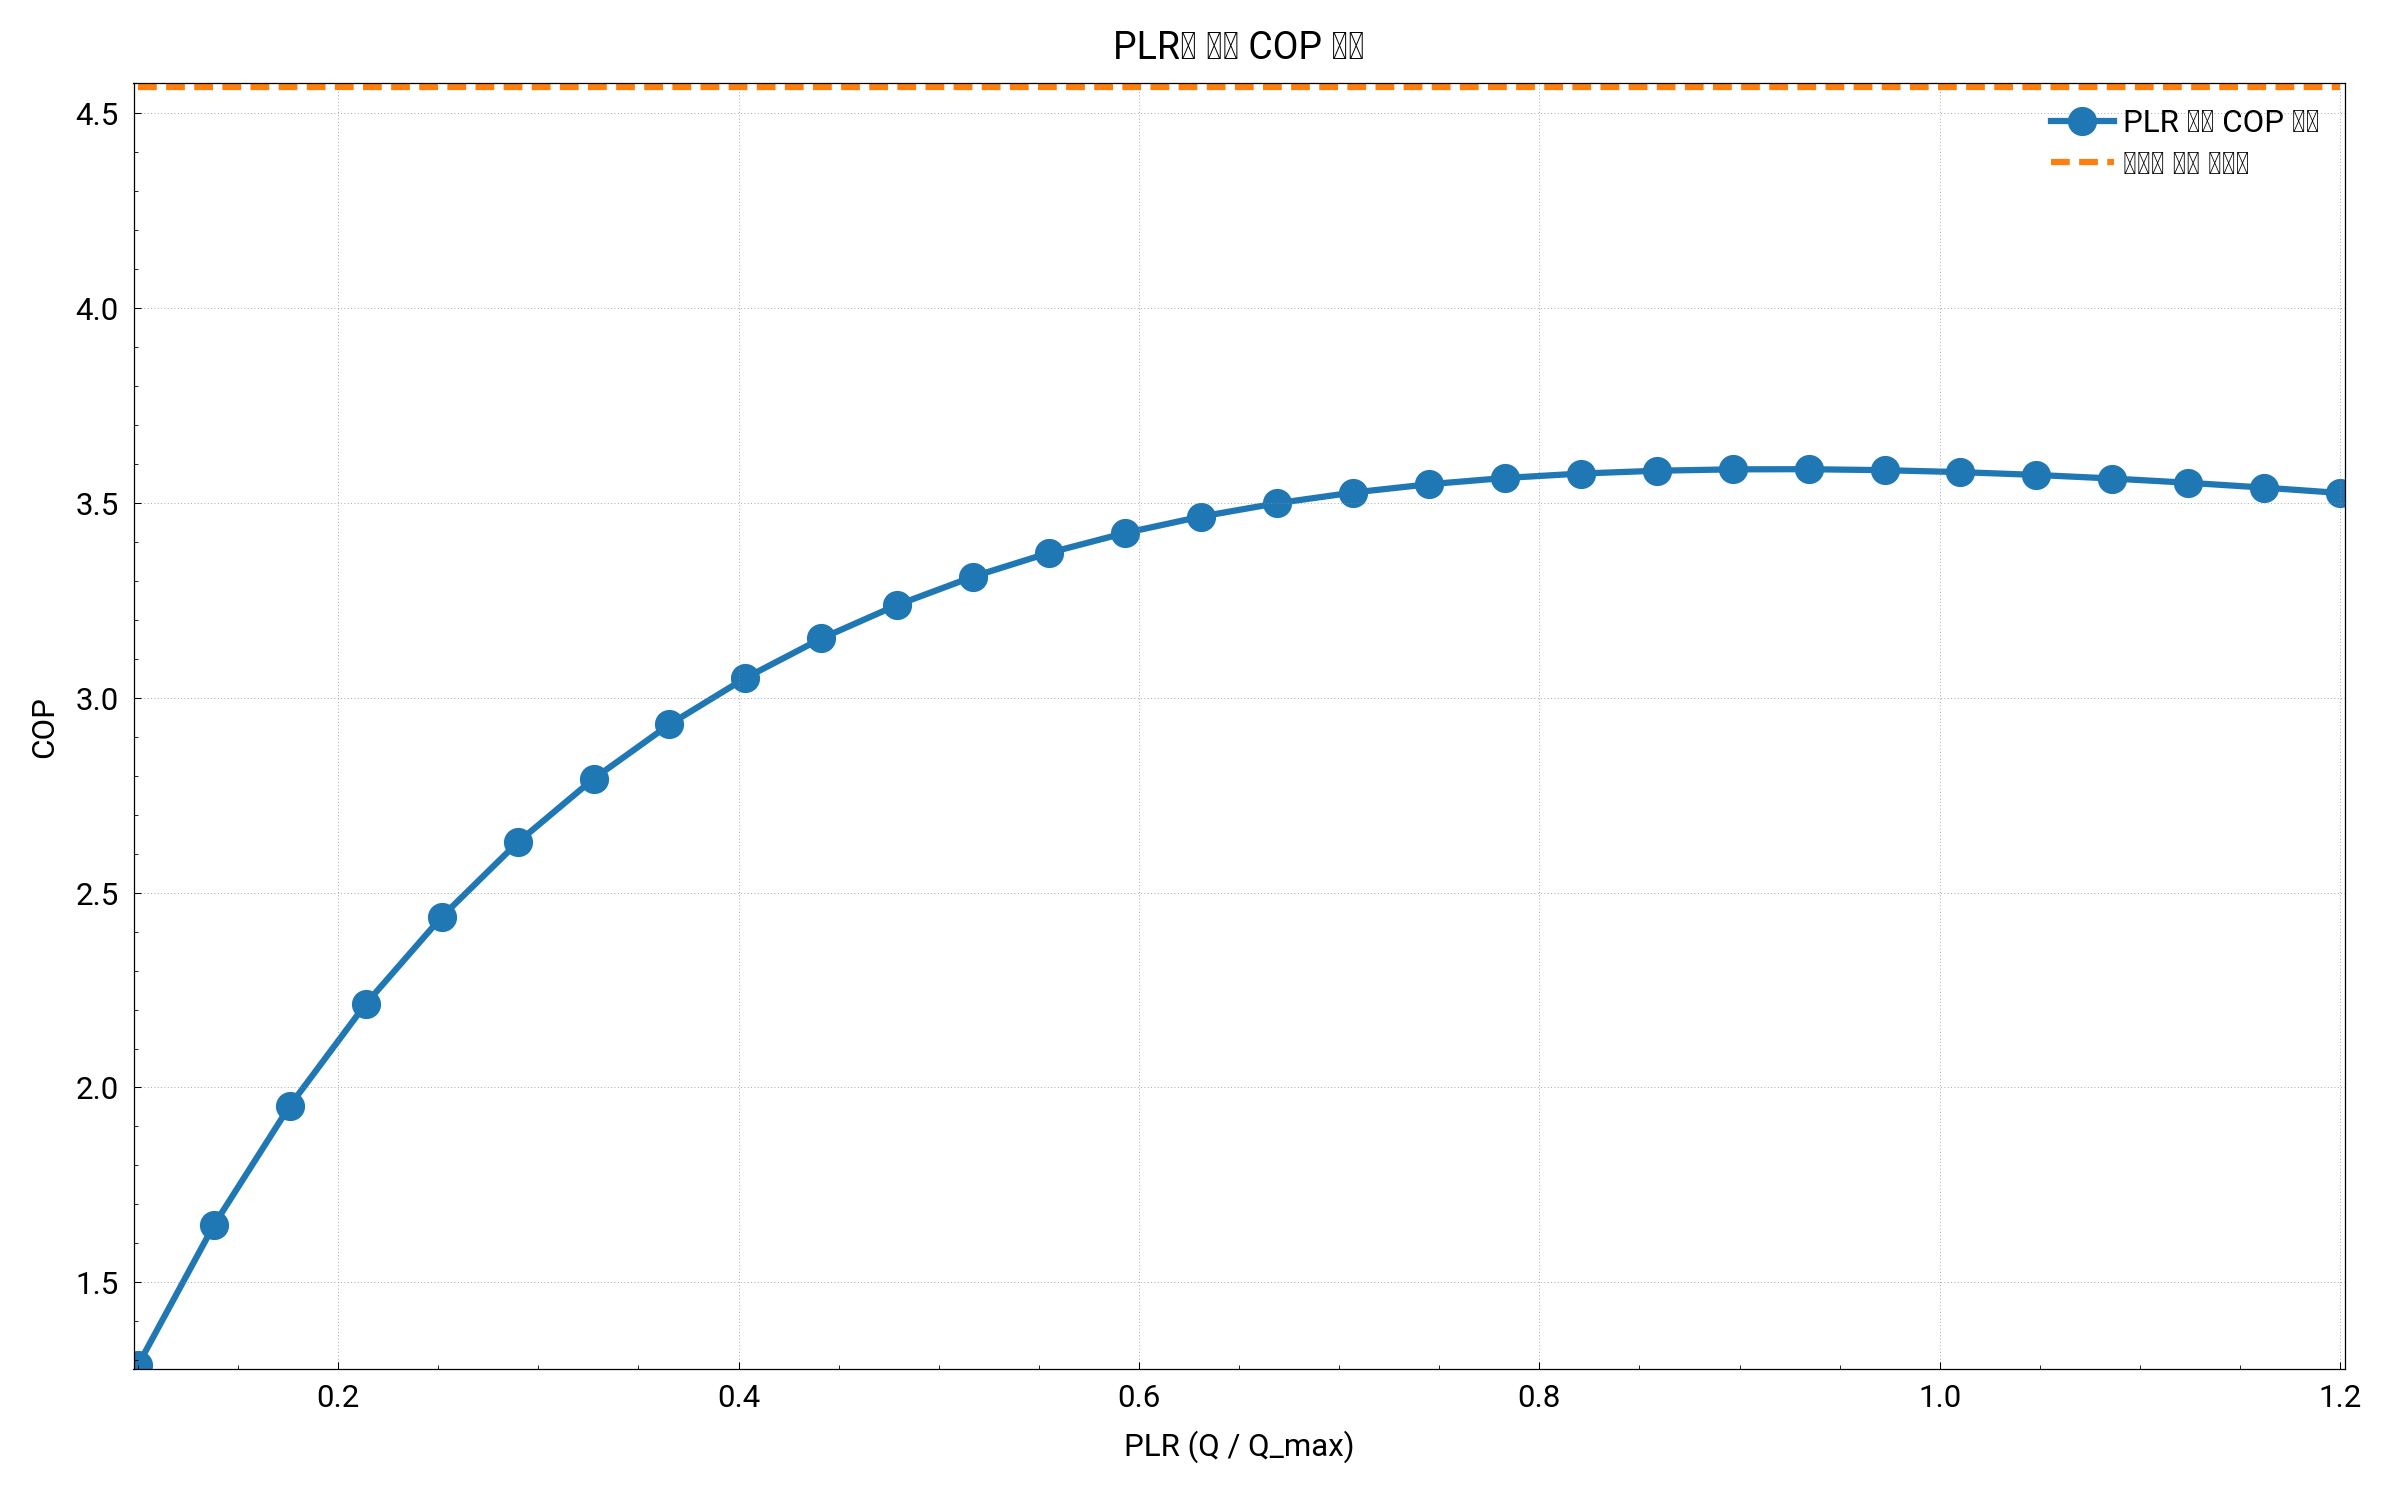

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 설정값
Toa = 32  # 실외온도 [°C]
Tia = 22  # 실내온도 [°C]
max_load = 25000  # 최대 냉방 부하 [W]

# PLR 범위 설정
PLR_range = np.linspace(0.1, 1.2, 30)
COP_PLR = []
COP_empirical = []

# delta_T 계산
delta_T = Toa - Tia
COP2 = 5.06 - 0.05 * delta_T + 0.00006 * delta_T**2

# PLR 기반 COP 계산
for PLR in PLR_range:
    Q = PLR * max_load

    # PLR 기반 경험식
    EIR_by_T = 0.38 + 0.02 * Tia + 0.01 * Toa
    EIR_by_PLR = 0.22 + 0.50 * PLR + 0.26 * PLR**2
    COP = PLR * 4.0 / (EIR_by_T * EIR_by_PLR)
    COP_PLR.append(COP)

    # 동일한 delta_T 기반 COP는 일정 (선형 그래프와 비교용)
    COP_empirical.append(COP2)

# 그래프 시각화
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(PLR_range, COP_PLR, label="PLR", marker='o')
ax.plot(PLR_range, COP_empirical, label="COP", linestyle='--')

ax.set_title("PLR에 따른 COP 비교")
ax.set_xlabel("PLR (Q / Q_max)")
ax.set_ylabel("COP")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()